<a href="https://colab.research.google.com/github/Alton01/computer_vision_pytorch/blob/main/computer_vision_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [32]:
train_data = datasets.FashionMNIST(
    root="data", # where data is to be downloaded to
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data", # where data is to be downloaded to
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [33]:
len(train_data), len(test_data)

(60000, 10000)

image shape: torch.Size([1, 28, 28]), label: 9


Text(0.5, 1.0, '9')

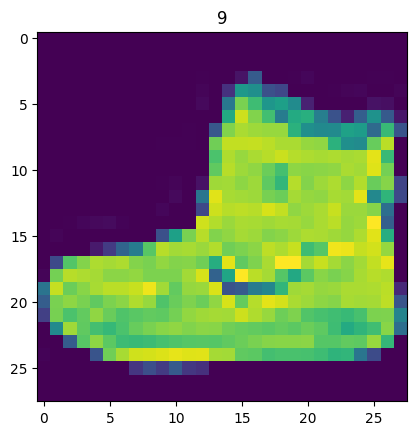

In [34]:
image, label = train_data[0]
print(f"image shape: {image.shape}, label: {label}")

plt.imshow(image.squeeze())
plt.title(label)

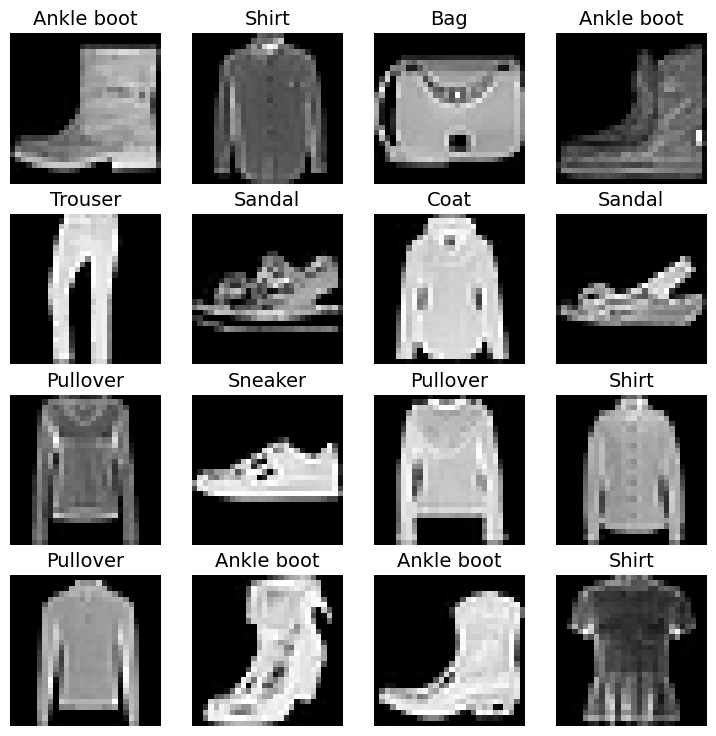

In [35]:
#visualizing the data
class_names = train_data.classes
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9)) #creates a square figure with both width and height set to 9 inches.
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray") # we squeeze to avoid problems with matplotlib by removing any 1 extra dimension
    plt.title(class_names[label], fontsize=14)
    plt.axis(False)

In [36]:
# Dataloader batchifies our data due to compute memory.
# it also gives our neural network more chances to update its gradient per epoch. at 32 images per batch instead of 60,000 images.
# our neural network updates its weight every 32 images thanks to the optimizer.

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78794cc6ab90>,
 <torch.utils.data.dataloader.DataLoader at 0x78794ba542d0>)

In [37]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [38]:
#structure of train_loader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

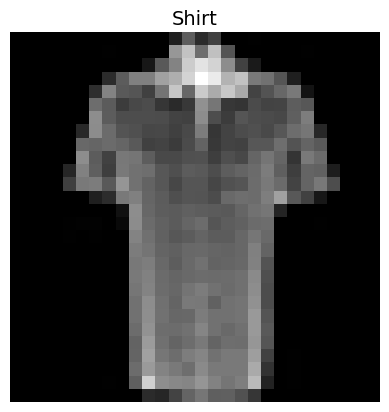

In [39]:
# show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label], fontsize=14)
plt.axis(False)

In [40]:
flatten_model = nn.Flatten() # flattens a contiguous range of dims into a tensor/vector. For use with sequential()
# condensing information down into a single vector space because we are also using a linear layer in the model
#  which cant handle multi dimensional data so we condense it into a single vector as input.
x = train_features_batch[0]

output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [41]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
    )

  def forward(self, x):
    return self.layer_stack(x)


In [42]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [43]:
import requests

from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [44]:
# loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [45]:
# function for timing our experiments

from timeit import default_timer as timer # measures execution time of code

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [46]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


5.6498996855225414e-05

In [47]:
# tqdm for progress bar

from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")

    #Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad() # clears gradients of model's parameters otherwise gradients from previous batches would accumulate.

        loss.backward() # calculates gradients of the loss with respect to the model's parameters

        optimizer.step() # updates the model's parameters based on the calculated gradients

        if batch % 400 == 0:
          print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader
    )

    # TESTING
    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
      for X_test, y_test in test_dataloader:

        test_pred = model_0(X_test) #output in logits

        test_loss += loss_fn(test_pred, y_test)

        test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) #use argmax to convert highest logit to label.

      # calculate test loss average per batch
      test_loss /= len(test_dataloader)

      # calculate test accuracy average per batch
      test_acc /= len(test_dataloader)


    print(f"\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.0387
Epoch: 1
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.1969
Epoch: 2
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.4265
Train time on cpu: 38.550 seconds
